## Initial algorithim with description

### Algorithm Steps

#### Libraries

In [1]:
import numpy as np
import scipy.stats as stats
import math
from PIL import Image
import matplotlib.pyplot as plt

Our Algorithim is composed of 3 functions: Indian Buffet Process, log likelyhood function, and the Gibbs Sampler 

#### I. Indian Buffett Process

The Indian Buffett Process is used to initialize our Z matrix. The function is designed based on the following steps described in the paper. 

1. Initial customer takes the first Poisson($\alpha$) dishes  
2. The following ith customers:  
a. Take dishes that have previously been taken with probability of $\frac{m_k}{i}$ where $m_k$ is the number of customers who           have tried the dish  
b. Try Poisson($\alpha$/i) number of new dishes

In [2]:
def IBP(alpha,N):
    """ Indian Buffett Process"""
    k = alpha * N * 10
    Z = np.zeros((N,k))
    
    #initial customer
    d = np.random.poisson(alpha)
    Z[0,0:d] = 1

    k_new = d
    #Rest of the customers
    for i in range(1,N):
        for j in range(k_new):
            probability = np.sum(Z[0:i,j])/(i + 1)
            if probability > np.random.random():
                Z[i,j] = 1
        d = np.random.poisson(alpha/(i + 1))
        Z[i,k_new:k_new + d] = 1
        k_new += d
        
    return Z[:,0:k_new]
        
            

#### II. Log Likelyhood Function

This is a helper function that is frequently referenced during the Gibbs Sampler. It it is the log of the likelyhood of p(X | Z, $\sigma_X$, $\sigma_A$)

In [3]:
def log_likelyhood(N,D,K,sigma_X,sigma_A,Z):
    M = Z.T @ Z + (sigma_X**2/sigma_A**2)*np.eye(K)
    part1 = N*D/2 * np.log(2*np.pi) + (N - K)*D*np.log(sigma_X) + K*D*np.log(sigma_A)+D/2*np.log(np.linalg.det(M))
    part2_inside = np.eye(N) - (Z @ np.linalg.inv(M) @ Z.T)
    part2 = -1/(2 * sigma_X**2) * np.trace(X.T @ part2_inside @ X)
    return part2 - part1

#### III. Gibbs Sampler

This is the main portion of our function and does the following steps:  
1. For each $Z_{ik}$, sample to see if it is 0 or 1
2. Sample to see if more columns should be added (increase k) or potentially be removed
3. Update $\sigma_X$ as needed
4. Update $\sigma_A$ as needed
5. Compute new $\alpha$

In [4]:
def sampler(X,alpha,niter,epsilon,sigma_X,sigma_A,alpha_a_prior,alpha_b_prior,max_new):
    N = X.shape[0]
    D = X.shape[1]
    Z = IBP(alpha,N) # set inital Z
    K = Z.shape[1]
    K_values = np.zeros(niter)
    alpha_values = np.zeros(niter)
    Sigma_X_values = np.zeros(niter)
    Sigma_A_values = np.zeros(niter)
    HN = 0
    for i in range(1,N+1):
        HN += 1.0/i
    for runs in range(niter):
        for i in range(N):
            for j in range(K):
                #Sample Z given conditionals
                
                col_k_count = sum(Z[:,j]) - Z[i,j] #p(zik|z-ik) = 0 so we set to 0
                if col_k_count == 0:
                    Z[i,j] = 0
                    
                else:
                    Z[i,j] = 0
                    Z0_p = log_likelyhood(N,D,K,sigma_X,sigma_A,Z) + np.log(N - col_k_count)
                    Z[i,j] = 1
                    Z1_p = log_likelyhood(N,D,K,sigma_X,sigma_A,Z) + np.log(col_k_count)
                    L = Z1_p - Z0_p
                    if L > 40: #helps with overflow
                        Z[i,j] = 1
                    elif L < -40:
                        Z[i,j] = 0
                    elif np.exp(L)/(1 + np.exp(L)) > np.random.random():
                        Z[i,j] = 1
                    else:
                        Z[i,j] = 0
                        
            #Sample to see if new columns get added
            log_prob = np.zeros(max_new)
            a_N = alpha/N
            log_prob[0] = -a_N + log_likelyhood(N,D,Z.shape[1],sigma_X,sigma_A,Z)
            for new_ks in range(1,max_new):
                new_cols = np.zeros((N,new_ks))
                new_cols[i,:] = 1
                Z_new = np.hstack((Z,new_cols))
                #Poisson(alpha/n) * log likelyhood
                log_prob[new_ks] = new_ks*np.log(a_N) - a_N - np.log(math.factorial(new_ks)) + log_likelyhood(N,D,Z_new.shape[1],sigma_X,sigma_A,Z_new)
            #Convert log likelyhoods
            prob = np.exp(log_prob - max(log_prob))
            prob = prob/sum(prob)

            #Sample probabilites and add columns accordingly
            new_cols_add = list(np.random.multinomial(1,prob) == 1).index(1)
            col_k_count = np.sum(Z,axis = 0) - Z[i,:]
            if new_cols_add == 0:
                Z = Z[:,col_k_count != 0]
            else:
                newcols = np.zeros((N,new_cols_add))
                newcols[i,:] = 1
                Z = np.hstack((Z[:,col_k_count != 0],newcols))
            K = Z.shape[1]
        
        #Part2
        current_likelyhood = log_likelyhood(N,D,K,sigma_X,sigma_A,Z) 
        
        #Sigma_X
        sigma_X_new = sigma_X + np.random.uniform(-epsilon,epsilon)
        new_likelyhood = log_likelyhood(N,D,K,sigma_X_new,sigma_A,Z)
        if new_likelyhood - current_likelyhood >= 0:
            sigma_X = sigma_X_new
        elif np.exp(new_likelyhood - current_likelyhood) > np.random.random():
            sigma_X = sigma_X_new
        else:
            sigma_X = sigma_X
            
        #Sigma_A
        sigma_A_new = sigma_A + np.random.uniform(-epsilon,epsilon)
        new_log_likelyhood = log_likelyhood(N,D,K,sigma_X,sigma_A_new,Z)
        if new_likelyhood - current_likelyhood >= 0:
            sigma_A = sigma_A_new
        elif np.exp(new_likelyhood - current_likelyhood) > np.random.random():
            sigma_A = sigma_A_new
        else:
            sigma_A = sigma_A
         
        #Alpha
        alpha = np.random.gamma(alpha_a_prior + K,alpha_b_prior + 1/(1 + HN))
        
        K_values[runs] = K
        alpha_values[runs] = alpha
        Sigma_X_values[runs] = sigma_X
        Sigma_A_values[runs] = sigma_A
        print(runs,K,sigma_X)
    return(K_values,alpha_values,Sigma_X_values,Sigma_A_values,Z)

## Simulation

For this simulation, we will use the example images used in Ilker Yildirim's paper (https://www2.bcs.rochester.edu/sites/jacobslab/cheat_sheet/IndianBuffetProcess.pdf) to see if our algorithm can produce similar results. 

### Setup

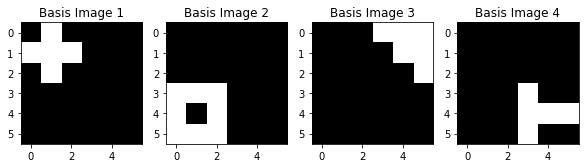

In [24]:
np.random.seed(1)
#We have 4 basis images:
N = 100
D = 36
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4,figsize = (10,4))
b1 = np.array([[0,1,0,0,0,0],
               [1,1,1,0,0,0],
               [0,1,0,0,0,0],
               [0,0,0,0,0,0],
               [0,0,0,0,0,0],
               [0,0,0,0,0,0]])

ax1.imshow(b1,cmap = "gray")
ax1.set_title("Basis Image 1")


b2 = np.array([[0,0,0,0,0,0],
               [0,0,0,0,0,0],
               [0,0,0,0,0,0],
               [1,1,1,0,0,0],
               [1,0,1,0,0,0],
               [1,1,1,0,0,0]])

ax2.imshow(b2,cmap = "gray")
ax2.set_title("Basis Image 2")


b3 = np.array([[0,0,0,1,1,1],
               [0,0,0,0,1,1],
               [0,0,0,0,0,1],
               [0,0,0,0,0,0],
               [0,0,0,0,0,0],
               [0,0,0,0,0,0]])

ax3.imshow(b3,cmap = "gray")
ax3.set_title("Basis Image 3")

b4 = np.array([[0,0,0,0,0,0],
               [0,0,0,0,0,0],
               [0,0,0,0,0,0],
               [0,0,0,1,0,0],
               [0,0,0,1,1,1],
               [0,0,0,1,0,0]])

ax4.imshow(b4,cmap = "gray")
ax4.set_title("Basis Image 4")
pass

b1 = b1.reshape(D)
b2 = b2.reshape(D)
b3 = b3.reshape(D)
b4 = b4.reshape(D)
sigmaX = 0.5

#Create X from basis vectors
zb1 = np.outer(np.random.binomial(1,.5,100),b1)
zb2 = np.outer(np.random.binomial(1,.5,100),b2)
zb3 = np.outer(np.random.binomial(1,.5,100),b3)
zb4 = np.outer(np.random.binomial(1,.5,100),b4)

X = zb1 + zb2 + zb3 + zb4
#Add noise
X = X + np.random.normal(0,sigmaX,(N,D))

### Run Gibbs Sampler for X

In [ ]:
np.random.seed(4)
Ks,Alpha,SXs,SAs,Z = sampler(X,1,1000,.05,1,1,1,1,4)

### Get Feature Matrix A and plot

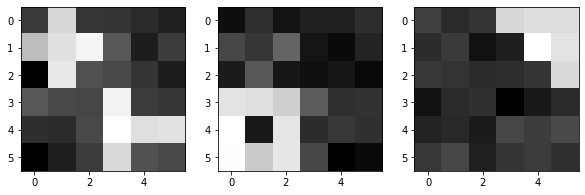

In [30]:
A = np.linalg.inv(Z.T @ Z + SXs[999]**2 / SAs[999]**2 * np.eye(int(Ks[999]))) @ Z.T @ X
fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize = (10,4))
ax1.imshow(A[0].reshape(6,6),cmap = "gray")
ax2.imshow(A[1].reshape(6,6),cmap = "gray")
ax3.imshow(A[2].reshape(6,6),cmap = "gray")
pass

### Values of K, $\alpha$, $\sigma_X$,$\sigma_A$

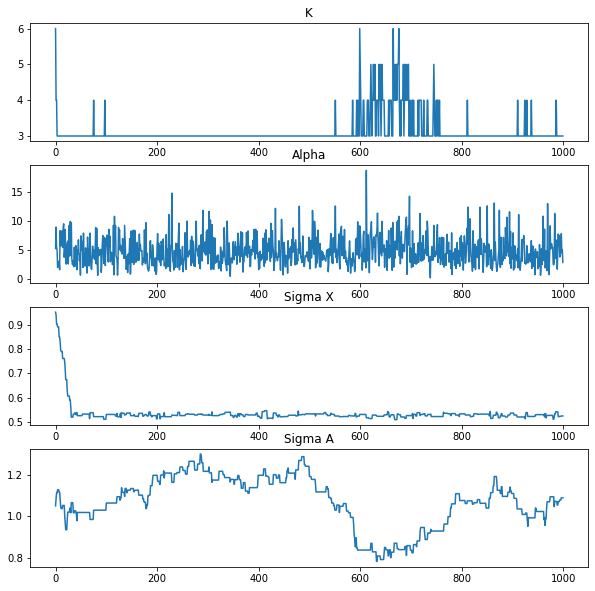

In [32]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1,figsize = (10,10))
ax1.plot(Ks)
ax1.set_title("K")
ax2.plot(Alpha)
ax2.set_title("Alpha")
ax3.plot(SXs)
ax3.set_title("Sigma X")
ax4.plot(SAs)
ax4.set_title("Sigma A")
pass

### Discussion

There are several things to note examining the results of the simulation. The returned latent features are very similiar to the basis vectors initially used with some difference in that it combined 2 of the images to only return 3 instead of the inital 4. As the iterations continued, we can see that the $\sigma_X$ converged to its true value of .5. The K value seemed to constantly fluctuate between 3 and 6 and finished with 3. Based on our results from the 3 latent features it seems that we would be capturing the same results just in a different form with the changes in k.  

## Real World Example

For this real world example, we will use images of each number of a dice. https://www.media4math.com/math-clip-art?field_la_display_title_value=%22Math+Clip+Art--Dice+and+Number+Models%22

### Setup

In [33]:
#Convert each dice to an array
One = np.array(Image.open('One.png').convert('L'))
Two = np.array(Image.open('Two.png').convert('L'))
Three = np.array(Image.open("Three.png").convert("L"))
Four = np.array(Image.open("Four.png").convert("L"))
Five = np.array(Image.open("Five.png").convert("L"))
Six = np.array(Image.open("Six.png").convert("L"))
#Make sure it is binary
One[One > 0] = 1
Two[Two > 0] = 1
Three[Three > 0] = 1
Four[Four > 0] = 1
Five[Five > 0] = 1
Six[Six > 0] = 1
#Reduce the dimensions
One = One[25:200:5,25:200:5]
Two = Two[25:200:5,25:200:5]
Three = Three[25:200:5,25:200:5]
Four = Four[25:200:5,25:200:5]
Five = Five[25:200:5,25:200:5]
Six = Six[25:200:5,25:200:5]

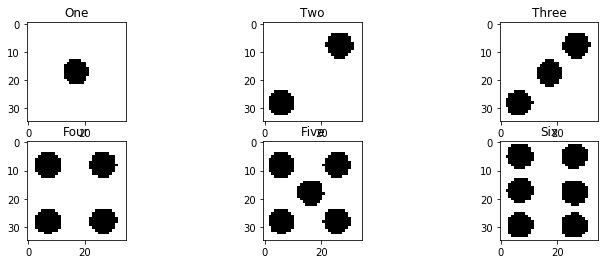

In [34]:
fig, ax = plt.subplots(2, 3,figsize = (12,4))
ax[0,0].imshow(One,cmap = "gray")
ax[0,0].set_title("One")
ax[0,1].imshow(Two,cmap = "gray")
ax[0,1].set_title("Two")
ax[0,2].imshow(Three,cmap = "gray")
ax[0,2].set_title("Three")
ax[1,0].imshow(Four,cmap = "gray")
ax[1,0].set_title("Four")
ax[1,1].imshow(Five,cmap = "gray")
ax[1,1].set_title("Five")
ax[1,2].imshow(Six,cmap = "gray")
ax[1,2].set_title("Six")
pass

In [35]:
np.random.seed(1)
N = 50
D = One.shape[0]**2
One = One.reshape(D)
Two = Two.reshape(D)
Three = Three.reshape(D)
Four = Four.reshape(D)
Five = Five.reshape(D)
Six = Six.reshape(D)

sigmaX = 0.25

#Create X from basis vectors
One = np.outer(np.random.binomial(1,.5,N),One)
Two = np.outer(np.random.binomial(1,.5,N),Two)
Three = np.outer(np.random.binomial(1,.5,N),Three)
Four = np.outer(np.random.binomial(1,.5,N),Four)
Five = np.outer(np.random.binomial(1,.5,N),Five)
Six = np.outer(np.random.binomial(1,.5,N),Six)
X = One + Two + Three + Four + Five + Six
#Add noise
X = X + np.random.normal(0,sigmaX,(N,D))

### Run Gibbs Sampler for X

In [ ]:
np.random.seed(2)
Ks,Alpha,SXs,SAs,Z = sampler(X,1,500,.05,.4,.5,1,1,3)

### Get Feature Matrix A and plot

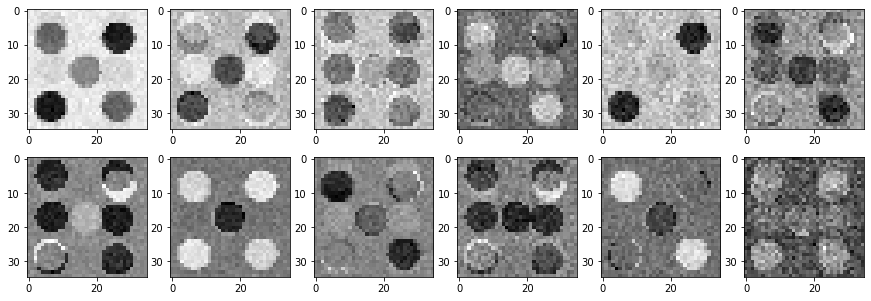

In [38]:
A = np.linalg.inv(Z.T @ Z + SXs[499]**2 / SAs[499]**2 * np.eye(int(Ks[499]))) @ Z.T @ X
fig, ax = plt.subplots(2, 6,figsize = (15,5))
ax[0,0].imshow(A[0].reshape(35,35),cmap = "gray")
ax[0,1].imshow(A[1].reshape(35,35),cmap = "gray")
ax[0,2].imshow(A[2].reshape(35,35),cmap = "gray")
ax[0,3].imshow(A[3].reshape(35,35),cmap = "gray")
ax[0,4].imshow(A[4].reshape(35,35),cmap = "gray")
ax[0,5].imshow(A[5].reshape(35,35),cmap = "gray")
ax[1,0].imshow(A[6].reshape(35,35),cmap = "gray")
ax[1,1].imshow(A[7].reshape(35,35),cmap = "gray")
ax[1,2].imshow(A[8].reshape(35,35),cmap = "gray")
ax[1,3].imshow(A[9].reshape(35,35),cmap = "gray")
ax[1,4].imshow(A[10].reshape(35,35),cmap = "gray")
ax[1,5].imshow(A[11].reshape(35,35),cmap = "gray")
# fig.delaxes(ax[1,5])
pass

### Values of K, $\alpha$, $\sigma_X$,$\sigma_A$

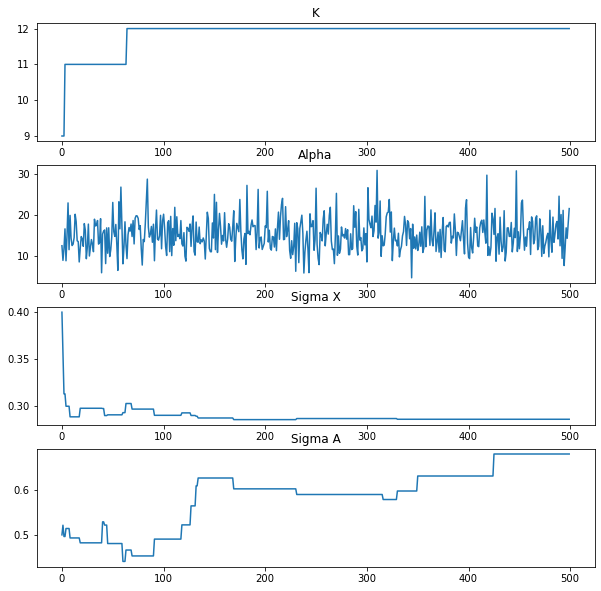

In [40]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1,figsize = (10,10))
ax1.plot(Ks)
ax1.set_title("K")
ax2.plot(Alpha)
ax2.set_title("Alpha")
ax3.plot(SXs)
ax3.set_title("Sigma X")
ax4.plot(SAs)
ax4.set_title("Sigma A")
pass

### Discussion

We began this process by first reading in images for each number on a dice which served as our basis images similiar to that in the simulation. Here, our sampler found 12 latent variables many of which look quite similiar to each other. The most common pattern seems to be 7 dots lined up trying to contain all the different dice positions.  Like in the simulation, once again our latent variables seem to capture the initial vectors quite well. K remained consistently at 12 for most of the run and $\sigma_X$ converged to the true value